# Introduction

It has been almost a year since I released alpha version of [universal-portfolios](https://github.com/Marigold/universal-portfolios). Although I didn't expect anyone to be interested in such niche area, people like Paul Perry took the idea and [pushed it further](http://nbviewer.ipython.org/github/paulperry/quant/blob/master/OLPS_Comparison.ipynb) and started a [fruitful discussion](https://www.quantopian.com/posts/comparing-olps-algorithms-olmar-up-et-al-dot-on-etfs#553a704e7c9031e3c70003a9) on Quantopian. Paul's ideas have waken me up from sleep and so I decided it's time to get serious about this and spent some weeks refining my approach to portfolio management. New version of universal-portfolios contains all tools I use to manage my own portfolio. Feel free to get inspired, but please stay suspicious, don't believe anything unless you try it yourself and know that the saying *"History repeats itself"* doesn't really apply to stock market.

# Load data

Nothing fancy, just init things and load ETFs we're going to work with **SPY, TLT, XLF, XLE, XLU, XLK, XLB, XLP, XLY, XLI, XLV** (S&P ETF and its components plus ETF for Treasury Bonds).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from datetime import datetime, date
import universal as up
from universal import tools
from universal import algos
import logging
import trading
reload(logging)
logging.basicConfig(level=logging.INFO)

from universal.algos import *

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16, 10) # increase the size of graphs
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 1
default_color_cycle = mpl.rcParams['axes.color_cycle'] # save this as we will want it back later

In [2]:
from pandas.io.data import DataReader

# load assets
symbols = ['SPY', 'TLT', 'XLF', 'XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV']
S = DataReader(symbols, 'yahoo', start=datetime(2003,1,1))['Adj Close']

# create other frequencies
mS = S.resample('M', how='last')
wS = S.resample('W', how='last')

# Can we beat uniform allocation (UCRP)?

Uniform portfolio, $\frac{1}{N}$ portfolio or uniform constant rebalanced portfolio (UCRP) means you invest equal proportion (that is $\frac{1}{N}$ where $N$ is number of assets) of your capital to each asset. Sounds too simple? In practice, it's [very hard to beat uniform portfolio](http://faculty.london.edu/avmiguel/DeMiguel-Garlappi-Uppal-RFS.pdf).

Note that we use weekly data. Daily data can be used as well, but the results are almost the same and doing analysis on weekly data is faster.

Summary:
    Profit factor: 1.29
    Sharpe ratio: 0.63
    Information ratio (wrt UCRP): 0.00
    Annualized return: 10.13%
    Annualized volatility: 15.12%
    Longest drawdown: 835 days
    Max drawdown: 47.76%
    Winning days: 58.9%
        


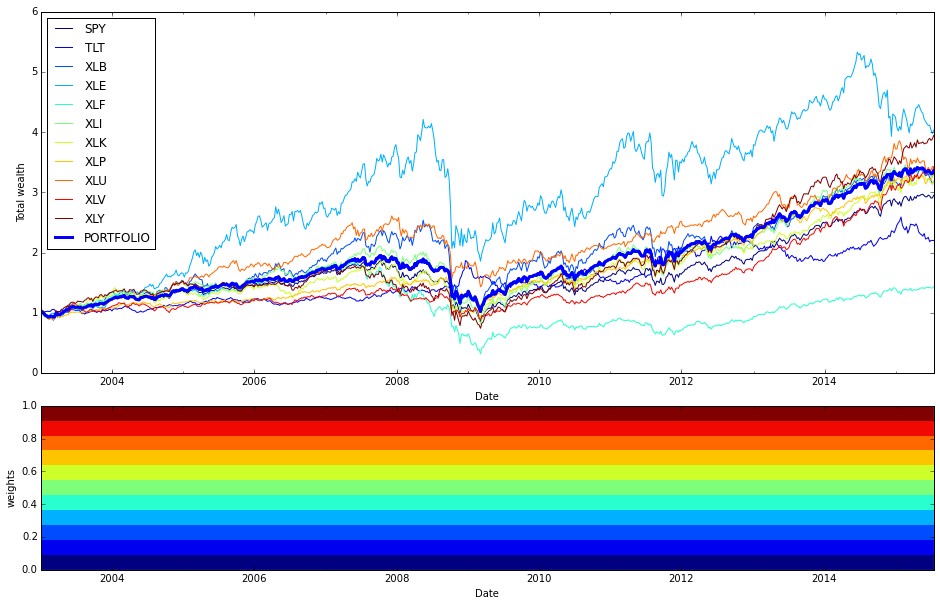

In [40]:
algo = CRP()
result = algo.run(wS)
print(result.summary())
_ = result.plot()

Some algorithms such as Universal portfolio even use best constant rebalanced portfolio (BCRP) as benchmark. BCRP is a portfolio whose weights are constant in time and is determined **in hindsight** (=can't be traded) to **maximize total return**. For our portfolio BCRP puts 57% to XLY and 43% to XLE.

Summary:
    Profit factor: 1.24
    Sharpe ratio: 0.55
    Information ratio (wrt UCRP): 0.22
    Annualized return: 12.26%
    Annualized volatility: 21.03%
    Longest drawdown: 666 days
    Max drawdown: 52.70%
    Winning days: 57.5%
        


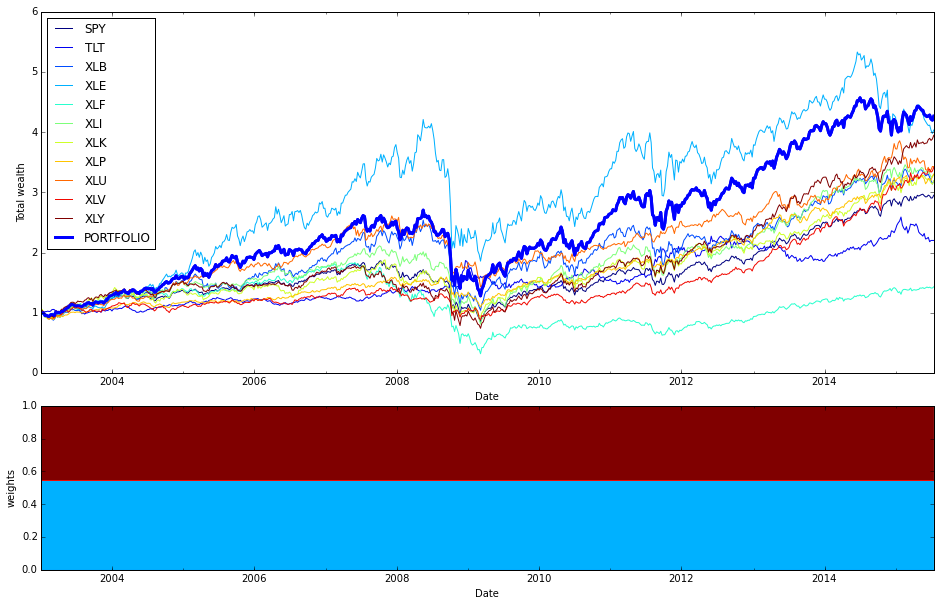

In [41]:
algo = BCRP()
result = algo.run(wS)
print(result.summary())
_ = result.plot()

BCRP is determined in hindsight, but we can use historical data to find BCRP for e.g. last year and hold it, hoping that history will repeat itself. Let's use last year (52 weeks) to determine BCRP.

Not that bad actually, return is indeed slightly higher than that of CRP, but sharpe ratio decreased. Adding transaction costs would kill us though. From my experience it usually performs worse than UCRP in both return and sharpe.

Summary:
    Profit factor: 1.21
    Sharpe ratio: 0.52
    Information ratio (wrt UCRP): 0.02
    Annualized return: 10.47%
    Annualized volatility: 18.97%
    Longest drawdown: 550 days
    Max drawdown: 32.54%
    Winning days: 58.5%
        


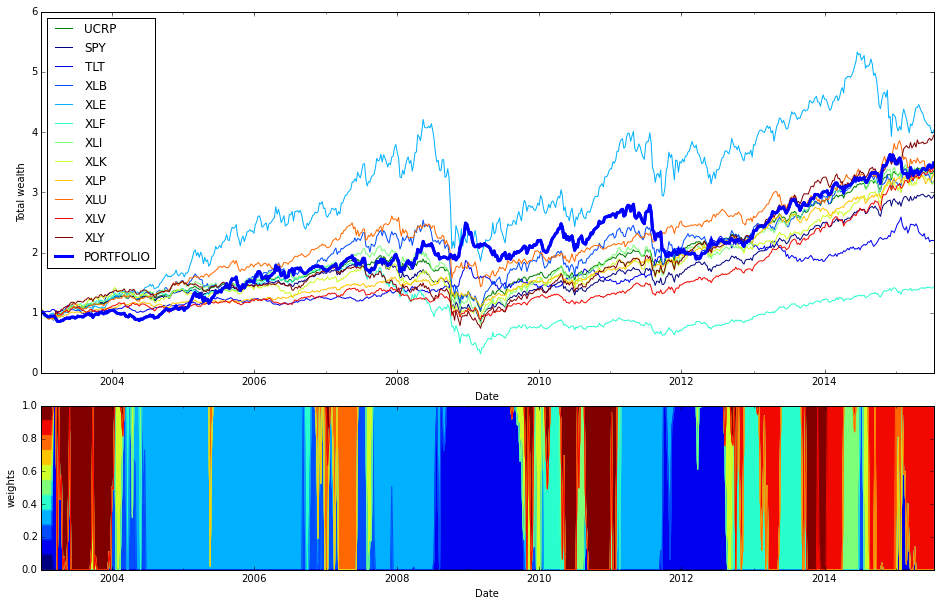

In [46]:
algo = DynamicCRP(n=52, min_history=8)
result = algo.run(wS)
print(result.summary())
_ = result.plot()

So what's wrong with this approach? We shouldn't care about return alone, but about **both return and volatility** which is summarized in sharpe ratio. We can always use leveraged ETFs to increase return or use margin. Let's focus on **sharpe ratio** then.

First idea that comes into your mind is **optimizing BCRP for sharpe ratio instead of return**. This idea got quite popular by Frank Grossman on [seekingalpha](http://seekingalpha.com/article/2714185-the-spy-tlt-universal-investment-strategy). 

There's one technicality we need to take care of. Sharpe ratio with zero risk free rate is defined as
$$
sh = \frac{\mu}{\sigma},
$$
where $\mu$ is expected value of our strategy and $\sigma$ is its standard deviation (volatility). Optimization can get hard since $\sigma$ can go to zero in case of portfolio holding only cash. We will therefore add "regularization" term $\alpha > 0$
$$
sh_{reg} = \frac{\mu}{\sigma + \alpha},
$$
Setting $\alpha$ to zero will give you zero portfolio with zero volatility and zero return (assuming zero risk-free rate). Setting $\alpha \rightarrow \infty$ will its maximize return. Thus $\alpha$ works as a [**risk-aversion**](https://en.wikipedia.org/wiki/Modern_portfolio_theory#Efficient_frontier_with_no_risk-free_asset) parameter controlling tradeoff between volatility and return. Try setting $\alpha$ to different values to see how it influences your return and sharpe ratio.

Another way of fixing ill-posed problem of maximizing sharpe ratio is to force no cash constraint, that is all weights must sum to 1. 

Summary:
    Profit factor: 1.36
    Sharpe ratio: 0.81
    Information ratio (wrt UCRP): -0.09
    Annualized return: 8.63%
    Annualized volatility: 10.21%
    Longest drawdown: 758 days
    Max drawdown: 20.44%
    Winning days: 61.6%
        


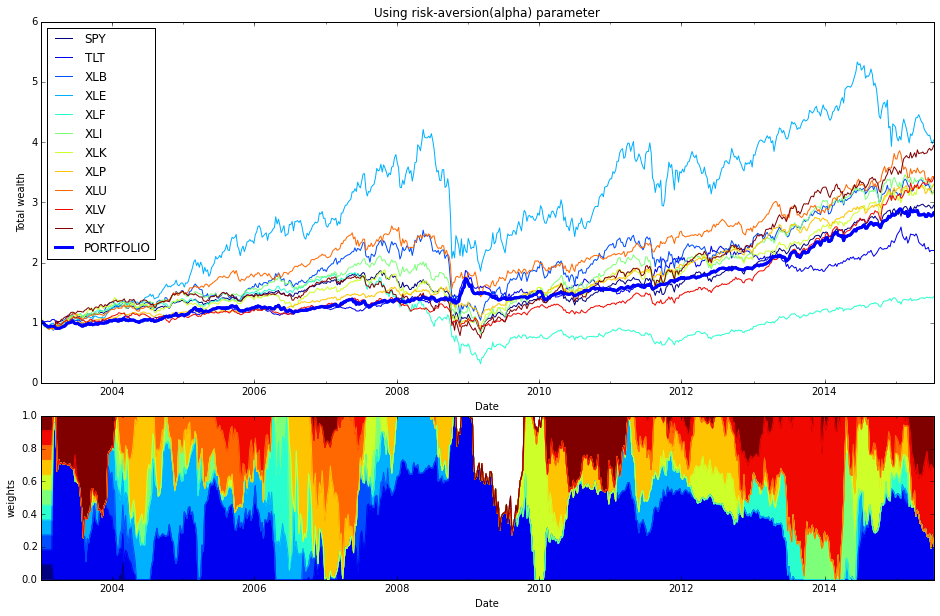

In [65]:
algo = DynamicCRP(n=52, min_history=8, metric='sharpe', alpha=0.01)
result = algo.run(wS)
print(result.summary())
_ = result.plot(title='Using risk-aversion(alpha) parameter')

Summary:
    Profit factor: 1.36
    Sharpe ratio: 0.80
    Information ratio (wrt UCRP): -0.08
    Annualized return: 8.69%
    Annualized volatility: 10.40%
    Longest drawdown: 719 days
    Max drawdown: 25.20%
    Winning days: 62.1%
        


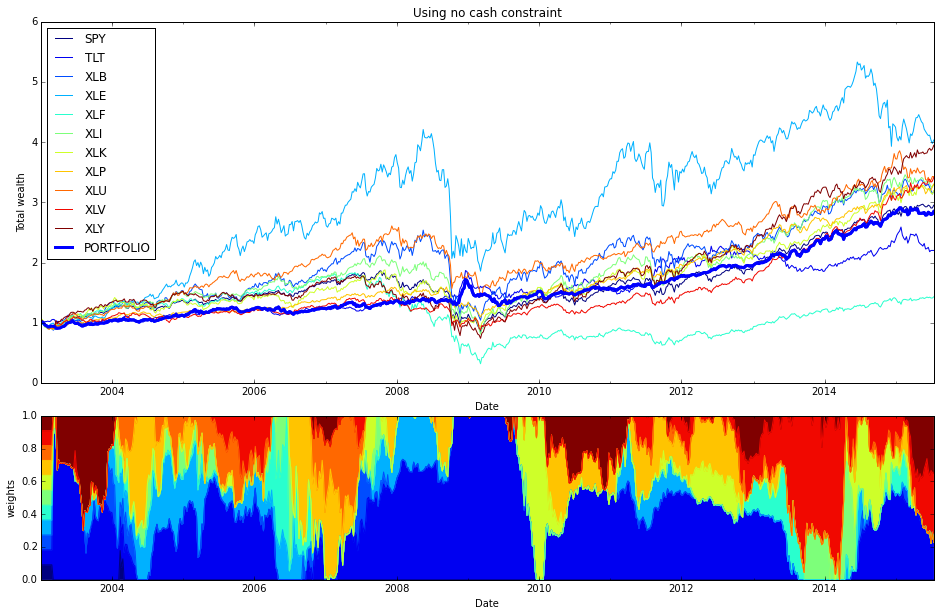

In [60]:
algo = DynamicCRP(n=52, min_history=8, metric='sharpe', no_cash=True)
result = algo.run(wS)
print(result.summary())
_ = result.plot(title='Using no cash constraint')

See how we **increased sharpe ratio** from 0.63 to 0.80 just by changing optimization objective?

# Let's start being normal

CRP, BCRP and DynamicCRP were all non-parametric. We didn't assume any particular distribution for returns, just took historical data as sample points and optimized specific objective. This makes sense considering that stock returns are not normal (resp. log-normal). However, they are pretty close to normal and since it's such a pleasure to work with normally distributed data, we will accept this assumptions.

I guess you have alerady heard of [Markowitz Portfolio aka Modern Portfolio Theory (MPT)](https://en.wikipedia.org/wiki/Modern_portfolio_theory). The theory behind it is so elegant it would be a pity if it didn't work in practice... According to many [it doesn't](https://en.wikipedia.org/wiki/Modern_portfolio_theory#Poor_model). Package `universal-portfolios` only used Kelly portfolio ([same as tangency portfolio](http://epchan.blogspot.cz/2014/08/kelly-vs-markowitz-portfolio.html) with risk-free asset) which performed poorly because it allowed shorting which resulted in extreme positions. New algo MPT restrict portfolio to long only and that weights must sum to 1.

As in [MPT](https://en.wikipedia.org/wiki/Modern_portfolio_theory#Efficient_frontier_with_no_risk-free_asset) use `method='mpt'` to minimize
$$
w^T \Sigma w - q \mu^T w
$$
where $q$ is a risk-aversion parameter (remember $\alpha$?) which controls trade-off between return and volatility. By setting $q = 0$ you will get so-called [minimum-variance portfolio](http://www.hillsdaleinv.com/portal/uploads/Minimum-Variance_Portfolio_Composition,_Roger_Clarke,_Harindra_de_Silva,_Steven_Thorley1.pdf) which has good [empirical performance](https://www.quantopian.com/posts/improved-minimum-variance-portfolio). Setting $q \rightarrow \infty$  maximizes return.

Summary:
    Profit factor: 1.62
    Sharpe ratio: 1.26
    Information ratio (wrt UCRP): 0.01
    Annualized return: 10.21%
    Annualized volatility: 7.71%
    Longest drawdown: 396 days
    Max drawdown: 14.93%
    Winning days: 59.2%
        


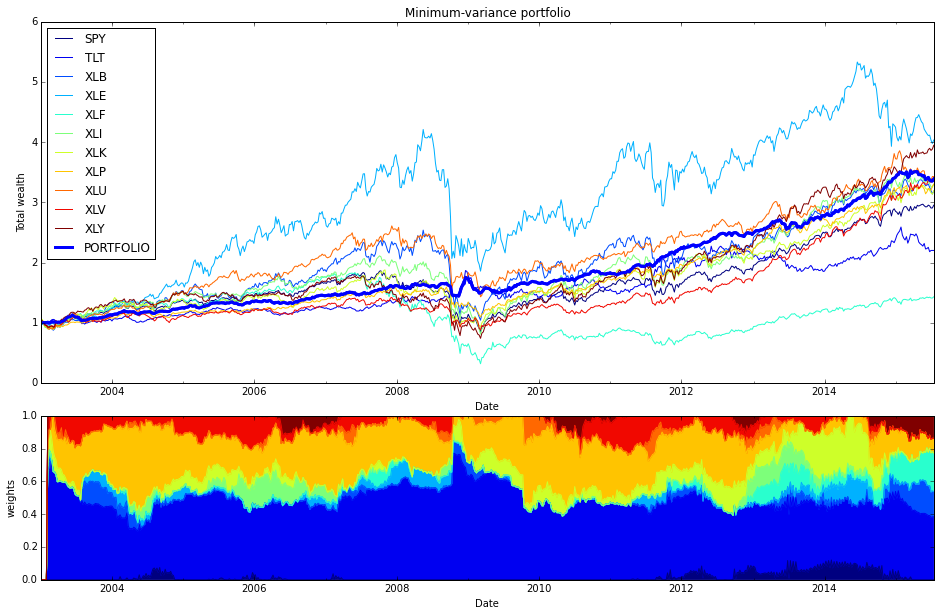

In [15]:
algo = MPT(window=52, min_history=4, mu_estimator='historical', cov_estimator='empirical', method='mpt', q=0.)
result = algo.run(wS)
print(result.summary())
_ = result.plot(title='Minimum-variance portfolio')

Minimum-variance portfolio has very good performance and is more stable (in terms of lower turnover) than `DynamicCRP`, however we'd like higher return. Let's set $q$ to higher value.

Summary:
    Profit factor: 1.36
    Sharpe ratio: 0.82
    Information ratio (wrt UCRP): -0.06
    Annualized return: 9.21%
    Annualized volatility: 10.77%
    Longest drawdown: 758 days
    Max drawdown: 20.50%
    Winning days: 60.8%
        


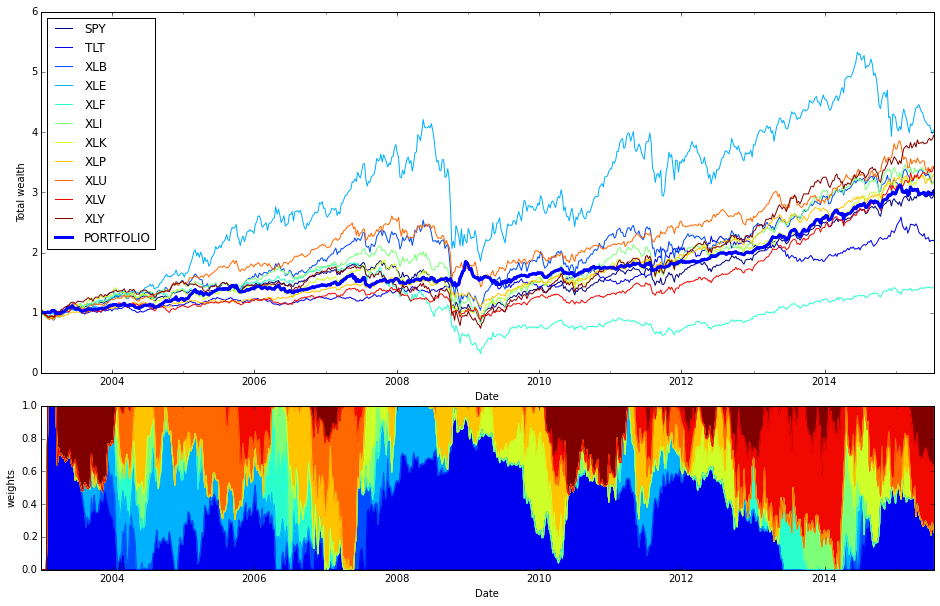

In [17]:
algo = MPT(window=52, min_history=4, mu_estimator='historical', cov_estimator='empirical', method='mpt', q=0.1)
result = algo.run(wS)
print(result.summary())
_ = result.plot()

Crap. Not even we got lower sharpe ratio, but we also got **lower return**!

# Don't bother with predictions

The reason why our portfolio with lower risk-aversion failed is that we put more focus on term $q \mu^T w$ which contains is based on **historical estimate** of returns. And unlike covariance matrix, future expected returns are notoriously difficult to estimate. If one wants higher return, he can remove stocks with low volatility from optimization and only use assets with high potential.

Another way is to make some assumptions and get **implied return** estimation. The most widespread is [Black-Litterman model](http://bfi.cl/papers/He%20Litterman%201999%20-%20The%20intuition%20behind%20the%20Black-Litterman%20model%20portfolios.pdf) that gets implied returns by assuming index weights (imagine market valuation of individual assets in S&P500 or 1/N portfolio) represent optimal allocation (we implicitly assume our covariance matrix estimation is the true covariance).

Since we want to work with various assets classes (not within one index), estimating implied returns from market valuation is not ideal. Also our covariance matrix estimation can vary a lot and be unstable if we had higher number of stocks. I'll therefore use much simpler assumption that **all assets have the same sharpe ratio**. That is
$$
sh = \frac{\mu}{\sigma} = c \quad \rightarrow \quad \mu = c \sigma \propto \sigma
$$
meaning that asset's return is proportional to its volatility. We don't really care about $c$ as our optimization problem becomes
$$
w^T \Sigma w - q \cdot c \cdot diag(\Sigma)^T w
$$
and $c$ will be part of our risk-aversion parameter (I chose $c=0.5$ by the way which seemed reasonable). Use `mu_estimator=sharpe` in `MPT` for this assumption.

Summary:
    Profit factor: 1.56
    Sharpe ratio: 1.16
    Information ratio (wrt UCRP): -0.02
    Annualized return: 9.85%
    Annualized volatility: 8.05%
    Longest drawdown: 372 days
    Max drawdown: 15.66%
    Winning days: 59.1%
        


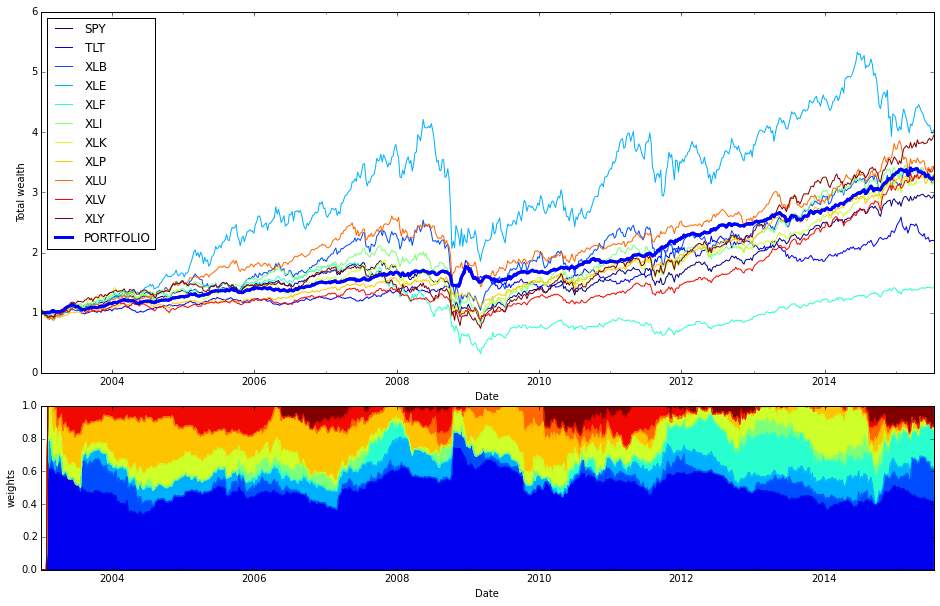

In [21]:
algo = MPT(window=52, min_history=4, mu_estimator='sharpe', cov_estimator='empirical', q=0.1)
result = algo.run(wS)
print(result.summary())
_ = result.plot()

Still not better than min-variance portfolio, but this is mainly due to ETFs selection. Try including risky assets (like leveraged ETFs) to see how $q$ controls return-variance tradeoff.

There are two more objectives in MPT you can optimize. The first one is `method='variance'` which minimizes portfolio variance
$$
w^T \Sigma w
$$
subject to constraint
$$
\mu^T w \geq q.
$$
In other words, find portfolio with minimal variance that given minimal return $q$.

The second one is `method='sharpe'` that maximizes sharpe ratio like we did with `DynamicCRP`
$$
sh_{reg} = \frac{\mu^T w}{w^T \Sigma w + q}
$$
where $q$ serves as risk-aversion parametere as before.

# Getting serious with statistics

If you use python for science, you have probably heard of awesome [scikit-learn](http://scikit-learn.org/). But I bet you didn't know that scikit-learn has methods for [robust covariance matrix estimation](http://scikit-learn.org/stable/modules/covariance.html). Those methods generally perform much better than simple maximum-likelihood covariance estimation. You can use them by specifying `cov_estimator='yourmethod'`, where `yourmethod` can be any of empirical, ledoit-wolf, graph-lasso or oas. You will see the difference when using short history or high number of assets. Ledoit and Wolf created [covariance estimation method](http://www.ledoit.net/ole2.pdf) targeted specifically at stock market and showed very good empirical performance. I didn't have time to implement it yet, but I'd be happy to accept a PR if anyone is be willing to do so.

Summary:
    Profit factor: 1.62
    Sharpe ratio: 1.26
    Information ratio (wrt UCRP): 0.01
    Annualized return: 10.23%
    Annualized volatility: 7.73%
    Longest drawdown: 333 days
    Max drawdown: 14.91%
    Winning days: 59.4%
        


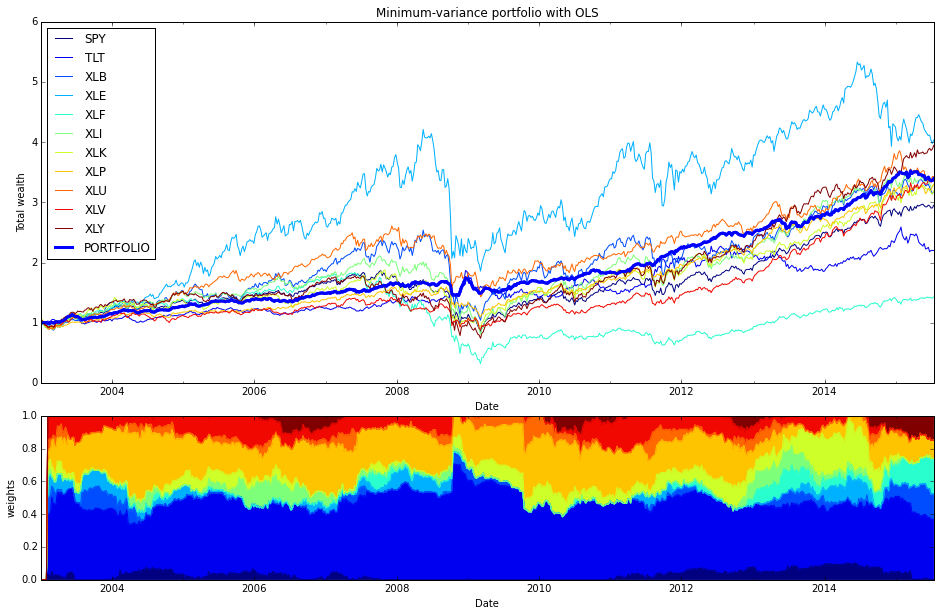

In [23]:
algo = MPT(window=52, min_history=4, cov_estimator='oas', method='mpt', q=0.)
result = algo.run(wS)
print(result.summary())
_ = result.plot(title='Minimum-variance portfolio with OLS')

# What else?

Besides MPT and DynamicCRP there are a few other features you might find useful

### tools.fill_synthetic_data(S, corr_threshold=0.95, backfill=False)
I used it to create synthetic history for leveraged ETFs. For example UPRO (3x leveraged long SPY) was introduced in 2009, but you can use SPY returns multiplied by 3 as a proxy (`fill_synthetic_data` estimates this multiplicator using regression).

INFO:root:Filling missing values of UPRO by 3.01*SPY (correlation 1.00)


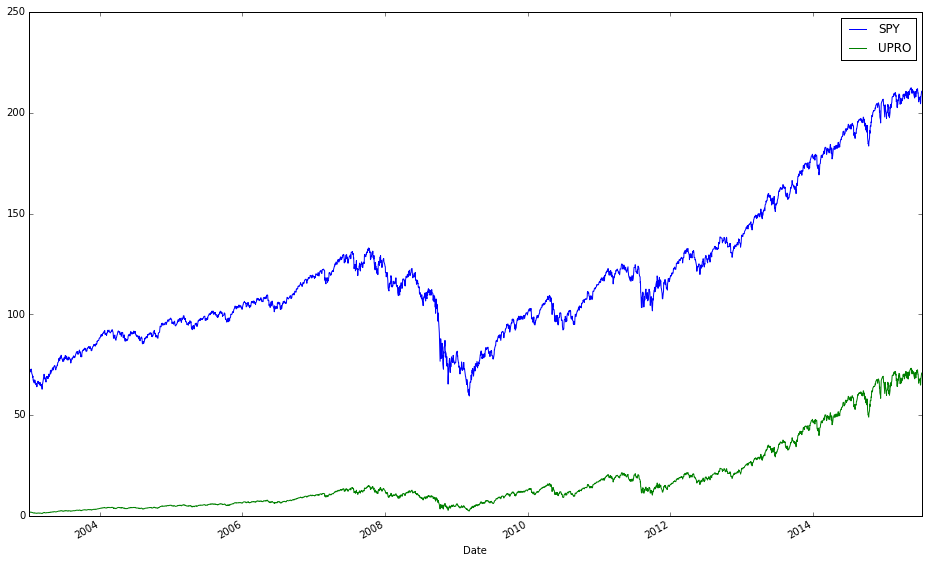

In [24]:
D = DataReader(['SPY', 'UPRO'], 'yahoo', start=datetime(2003,1,1))['Adj Close']
D = tools.fill_synthetic_data(D)
D.plot()

### tools.bootstrap_algo(S, algo, n, drop_fraction=0.1, random_state=None, n_jobs=-1)
Worried about overfitting? You should be! This method will drop each day with probability `drop_fraction` thereby creating new dataset with only `1-drop_fraction` of data left. It doesn't shuffle data anyhow.

In [25]:
algo = MPT(window=52, min_history=4, cov_estimator='empirical', method='mpt', q=0.)
list_results = tools.bootstrap_algo(wS, algo, 100, drop_fraction=0.1)

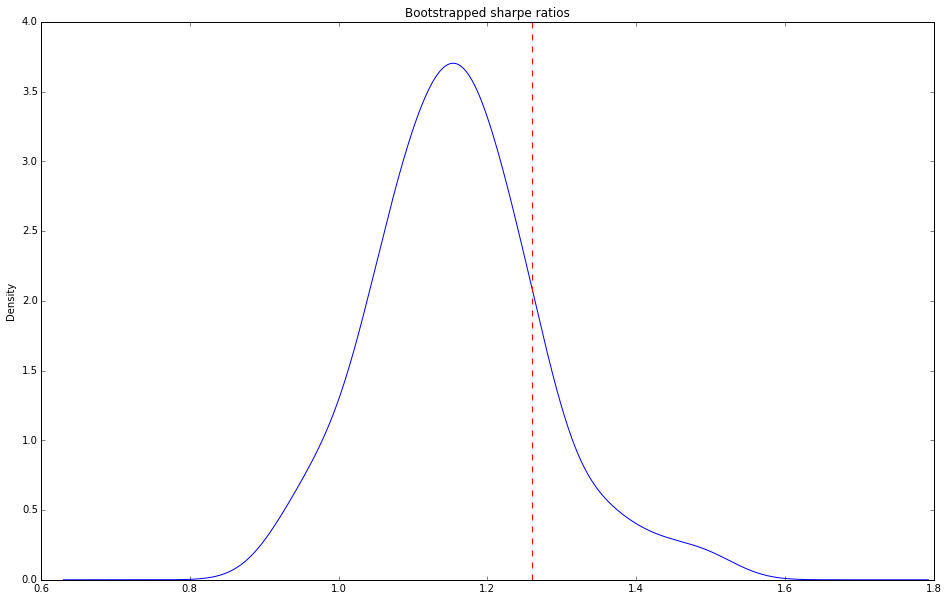

In [33]:
ax = pd.Series([r.sharpe for r in list_results]).plot(kind='kde', title='Bootstrapped sharpe ratios')
ax.axvline(1.26, color='r', linestyle='--')

So did we overfit? Probably yes, but the distribution of sharpe ratios looks like we can expect sharpe ratio around 1.15. We still have a bias though in picking assets and algorithm. It would be intersting to test the 

# What next?

If you want to go further, explore ETF world (I recommend leveraged ETFs) and see what works and what does not. Note that just selecting assets is *data snooping*, so don't expect that kind of performance in future.

There are several things I'd love to add to `universal-portfolios`, but don't have time for that
* implement [Ledoit-Wolf covariance estimation](http://www.ledoit.net/ole2.pdf)
* implement [Black-Litterman approach](http://bfi.cl/papers/He%20Litterman%201999%20-%20The%20intuition%20behind%20the%20Black-Litterman%20model%20portfolios.pdf) to allow for subjective opinions on returns